## House Prices - Advanced Regression Techniques
This Kaggle competition focuses on forecasting (predicting) the future house prices with a given dataset.

## 1. Problem Definition
in a statement:
`It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.`

## 2. Data
Data was collected from Kaggle competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

## 3. Evaluation
`Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)`

## 4. Features 
SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
MSSubClass: The building class
MSZoning: The general zoning classification
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access
Alley: Type of alley access
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to main road or railroad
Condition2: Proximity to main road or railroad (if a second is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Overall material and finish quality
OverallCond: Overall condition rating
YearBuilt: Original construction date
YearRemodAdd: Remodel date
RoofStyle: Type of roof
RoofMatl: Roof material
Exterior1st: Exterior covering on house
Exterior2nd: Exterior covering on house (if more than one material)
MasVnrType: Masonry veneer type
MasVnrArea: Masonry veneer area in square feet
ExterQual: Exterior material quality
ExterCond: Present condition of the material on the exterior
Foundation: Type of foundation
BsmtQual: Height of the basement
BsmtCond: General condition of the basement
BsmtExposure: Walkout or garden level basement walls
BsmtFinType1: Quality of basement finished area
BsmtFinSF1: Type 1 finished square feet
BsmtFinType2: Quality of second finished area (if present)
BsmtFinSF2: Type 2 finished square feet
BsmtUnfSF: Unfinished square feet of basement area
TotalBsmtSF: Total square feet of basement area
Heating: Type of heating
HeatingQC: Heating quality and condition
CentralAir: Central air conditioning
Electrical: Electrical system
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet
LowQualFinSF: Low quality finished square feet (all floors)
GrLivArea: Above grade (ground) living area square feet
BsmtFullBath: Basement full bathrooms
BsmtHalfBath: Basement half bathrooms
FullBath: Full bathrooms above grade
HalfBath: Half baths above grade
Bedroom: Number of bedrooms above basement level
Kitchen: Number of kitchens
KitchenQual: Kitchen quality
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
Functional: Home functionality rating
Fireplaces: Number of fireplaces
FireplaceQu: Fireplace quality
GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition
PavedDrive: Paved driveway
WoodDeckSF: Wood deck area in square feet
OpenPorchSF: Open porch area in square feet
EnclosedPorch: Enclosed porch area in square feet
3SsnPorch: Three season porch area in square feet
ScreenPorch: Screen porch area in square feet
PoolArea: Pool area in square feet
PoolQC: Pool quality
Fence: Fence quality
MiscFeature: Miscellaneous feature not covered in other categories
MiscVal: $Value of miscellaneous feature
MoSold: Month Sold
YrSold: Year Sold
SaleType: Type of sale
SaleCondition: Condition of sale

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import xgboost as xgb

In [2]:
def preprocessed_data(df):
    '''
    Performs transformations on df and returns transformed df.
    '''
    #Fill numeric rows
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label + '_is_missing'] = pd.isnull(content)
                df[label] = content.fillna(content.median())

    # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content) and label != 'YrSold':
            df[label+'_is_missing'] = pd.isnull(content)
    # We add +1 to the category cuz pandas encodes missing val as -1
            df[label] = pd.Categorical(content).codes+1

    return df

In [11]:
# Upload the training data
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_tmp = df.copy()
df_tmp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_tmp.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [6]:
df_tmp = preprocessed_data(df_tmp)

In [7]:
df_tmp.isna().sum()

Id                          0
MSSubClass                  0
MSZoning                    0
LotFrontage                 0
LotArea                     0
                           ..
PoolQC_is_missing           0
Fence_is_missing            0
MiscFeature_is_missing      0
SaleType_is_missing         0
SaleCondition_is_missing    0
Length: 127, dtype: int64

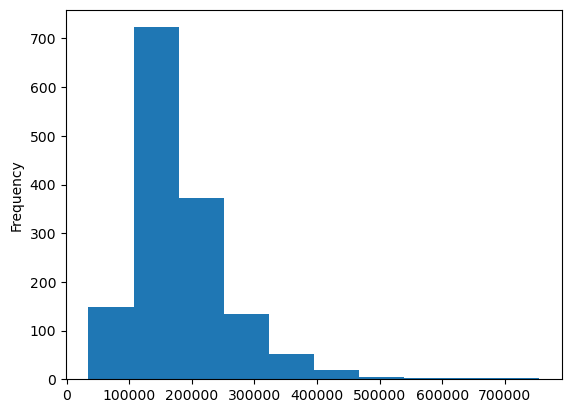

In [23]:
df_tmp.SalePrice.plot.hist();

In [8]:
X, y = df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice']

In [10]:
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageYrBlt_is_missing,GarageFinish_is_missing,GarageQual_is_missing,GarageCond_is_missing,PavedDrive_is_missing,PoolQC_is_missing,Fence_is_missing,MiscFeature_is_missing,SaleType_is_missing,SaleCondition_is_missing
0,1,60,4,65.0,8450,2,0,4,4,1,...,False,False,False,False,False,True,True,True,False,False
1,2,20,4,80.0,9600,2,0,4,4,1,...,False,False,False,False,False,True,True,True,False,False
2,3,60,4,68.0,11250,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False
3,4,70,4,60.0,9550,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False
4,5,60,4,84.0,14260,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False


## Standardizing our data

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Splitting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## LASSO Model

In [16]:
# Creating LASSO model
lasso = Lasso(alpha=1.0, max_iter=10000)
lasso.fit(X_train, y_train)

Lasso(max_iter=10000)

In [20]:
y_preds = lasso.predict(X_test)
y_preds[:10]

array([152672.41919144, 339892.26937662, 104092.64056617, 176730.04227588,
       315166.309301  ,  80291.20911967, 227272.63439259, 141166.26011209,
        79531.01823574, 158248.84012735])

In [25]:
def rmse (y_test, y_preds):
    '''
    Calculates the Root Mean Squared Error.
    '''
    return print(f'RMSE score : {np.sqrt(mean_squared_error(y_test, y_preds))}')

In [27]:
print(f'Coefficients {lasso.coef_}')

Coefficients [-2.60507795e+02 -3.06902615e+03 -9.31191923e+02 -1.50949449e+03
  3.77573555e+03  2.05354344e+03  2.30800564e+03 -1.46272523e+03
  2.44746641e+02 -1.01627410e+03 -5.70978303e+01  2.07788740e+03
  1.90679000e+03 -1.08722037e+02 -3.22685023e+03 -1.69357742e+03
 -3.00723363e+02  1.31987991e+04  6.09675168e+03  7.87545561e+03
  1.50257193e+03  7.87269641e+02  1.13522849e+03 -4.04598959e+03
  3.31041615e+03  5.89472484e+03  6.26827441e+03 -5.41687851e+03
  1.16472378e+02  5.33300938e+02 -8.09766801e+03  2.52114605e+03
 -2.71628660e+03  1.19169193e+03  1.33184965e+04  1.93966603e+03
  4.07505199e+03  5.27847526e+03  4.88562235e+03 -2.16743725e+02
 -5.11531481e+02  3.53254059e+02 -2.69332705e+02  1.20205637e+04
  1.68891043e+04  1.04811966e+02  3.46619528e+03  2.09891983e+03
 -4.92741970e+02  3.54440996e+02 -2.96158075e+01 -3.92970066e+03
 -4.80835022e+03 -6.18061655e+03  8.52154398e+03  4.31029310e+03
  7.02962676e+03 -9.60279003e+02  2.76930055e+02 -7.64249023e+02
 -4.63111121

In [30]:
lasso_cv = LassoCV(alphas=[0.1,0.5,1.0,10.0], cv=5)
lasso_cv.fit(X_train, y_train)

print(f'Optimal Alpha: {lasso_cv.alpha_}')

C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36553335503.26782, tolerance: 537415025.1745834
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31271789868.696045, tolerance: 537415025.1745834
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 944181283.0117188, tolerance: 537415025.1745834
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\linear

Optimal Alpha: 0.1


C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


In [32]:
lasso_optimal = Lasso(alpha=lasso_cv.alpha_)
lasso_optimal.fit(X_train, y_train)
y_opt_pred = lasso_optimal.predict(X_test)

# Evaluate again
opt_rmse = rmse(y_test, y_opt_pred)
print(f"Optimized Root Mean Squared Error: {opt_rmse}")

RMSE score : 38498.78674153194
Optimized Root Mean Squared Error: None


C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


In [34]:
lasso_optimal.score(X_test, y_test)

0.806767464572606

In [35]:
lasso.score(X_test, y_test)

0.8068768986487848

## XGBoost

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Instantiate an XGBoost regressor object
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = xg_reg.predict(X_test)

# Compute and print the mean squared error of the predictions
print(f"Mean Squared Error: {rmse(y_test, y_pred)}")
print(f'XGBoost score: {xg_reg.score(X_test, y_test)}')

RMSE score : 80639.82321663224
Mean Squared Error: None
XGBoost score: 0.15221583635953206


## HyperParameter Tuning

C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\pwrxn\miniconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


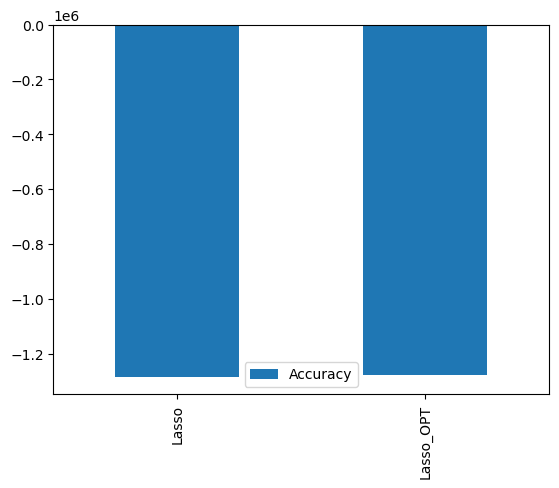

In [75]:
model_scores = {
                'Lasso' : lasso.score(X_test, y_test),
                'Lasso_OPT' : lasso_optimal.score(X_test, y_test)
               }

compare_models = pd.DataFrame(model_scores, index=['Accuracy'])
compare_models.T.plot.bar();

In [69]:
xgb_grid = {'objective': ['reg:squarederror'],
            'colsample_bytree' : [0.3,0.5,0.9], 
            'learning_rate' : [0.1,0.3,0.7],
            'max_depth' : [5,7,3],
            'alpha' : [10, 7, 14], 
            'n_estimators' : [50, 100, 200]}

In [70]:
np.random.seed(42)

rs_xgb = RandomizedSearchCV(xgb.XGBRegressor(),
                            param_distributions=xgb_grid,
                            cv=5,
                            n_iter=40,
                            verbose=True)

rs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=40,
                   param_distributions={'alpha': [10, 7, 14],
                                        'colsample_bytree': [0.3, 0.5, 0.9],
                                        'learning_rate': [0.1, 0.3, 0.7],
                                        'max_depth': [5, 7, 3],
                                        'n_estimators': [50, 100, 200],
                                        'objective': ['reg:squarederror']},
                   verbose=True)

In [71]:
rs_xgb.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 200,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.3,
 'alpha': 14}

In [72]:
rs_xgb.score(X_test, y_test)

0.9005008952013543

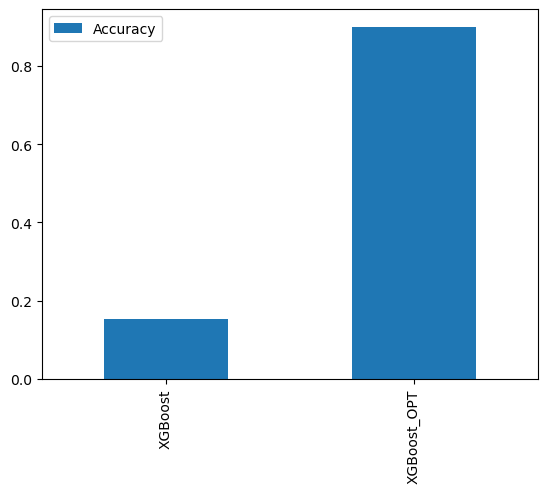

In [74]:
model_scores = {'XGBoost': xg_reg.score(X_test, y_test),
                'XGBoost_OPT': rs_xgb.score(X_test, y_test)
               }

compare_models = pd.DataFrame(model_scores, index=['Accuracy'])
compare_models.T.plot.bar();

## Make predictions on the test data

In [76]:
df_test = pd.read_csv('test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [77]:
df_test = preprocessed_data(df_test)
df_test.head()

C:\Users\pwrxn\AppData\Local\Temp\ipykernel_20216\3560944005.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label+'_is_missing'] = pd.isnull(content)
C:\Users\pwrxn\AppData\Local\Temp\ipykernel_20216\3560944005.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label+'_is_missing'] = pd.isnull(content)
C:\Users\pwrxn\AppData\Local\Temp\ipykernel_20216\3560944005.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageCars_is_missing,GarageArea_is_missing,GarageQual_is_missing,GarageCond_is_missing,PavedDrive_is_missing,PoolQC_is_missing,Fence_is_missing,MiscFeature_is_missing,SaleType_is_missing,SaleCondition_is_missing
0,1461,20,3,80.0,11622,2,0,4,4,1,...,False,False,False,False,False,True,False,True,False,False
1,1462,20,4,81.0,14267,2,0,1,4,1,...,False,False,False,False,False,True,True,False,False,False
2,1463,60,4,74.0,13830,2,0,1,4,1,...,False,False,False,False,False,True,False,True,False,False
3,1464,60,4,78.0,9978,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False
4,1465,120,4,43.0,5005,2,0,1,2,1,...,False,False,False,False,False,True,True,True,False,False


In [84]:
# Ensure df_test has the same columns as X_train
for column in X_train.columns:
    if column not in df_test.columns:
        df_test[column] = 0  # Or another default value as appropriate

# Reorder df_test columns to match X_train
df_test = df_test[X_train.columns]

best_model = rs_xgb.best_estimator_

# Now you can use best_model to make predictions on the test set
y_pred = best_model.predict(df_test)

In [85]:
test_preds

array([118931.36 , 151651.17 , 172187.42 , ..., 178310.17 , 126948.164,
       214163.97 ], dtype=float32)

In [86]:
df_preds = pd.DataFrame()
df_preds['Id'] = df_test['Id']
df_preds['SalePrice'] = test_preds
df_preds

,Id,SalePrice
0,1461,118931.359375
1,1462,151651.171875
2,1463,172187.421875
3,1464,188253.734375
4,1465,200395.703125
...,...,...
1454,2915,83145.734375
1455,2916,82371.523438
1456,2917,178310.171875
1457,2918,126948.164062


In [87]:
df_preds.to_csv('House_Prices_predictions_Kaggle_2.csv', index=False)

## Feature Importance

In [89]:
best_model.feature_importances_

array([7.6310278e-04, 2.8426591e-03, 1.2168174e-03, 1.0668024e-03,
       6.7038401e-03, 0.0000000e+00, 3.5458014e-04, 1.3522431e-03,
       4.6320148e-03, 0.0000000e+00, 2.6150048e-04, 1.0293697e-03,
       2.0615216e-03, 1.1413899e-03, 1.4230555e-02, 4.3221512e-03,
       1.5015567e-03, 1.6102406e-01, 2.9195335e-03, 1.9970607e-02,
       6.7266766e-03, 1.7219007e-03, 1.0436187e-03, 8.8025420e-04,
       3.4063545e-04, 7.1771292e-04, 3.0960238e-03, 1.3267316e-01,
       5.5794843e-04, 4.9718347e-04, 8.3910465e-02, 2.6140157e-03,
       1.9197569e-03, 1.3082552e-03, 1.3537734e-02, 2.3388185e-03,
       7.2264549e-04, 9.1348501e-04, 1.2525041e-02, 3.7927565e-04,
       3.4945176e-04, 1.4970732e-02, 2.5234360e-04, 3.0685443e-02,
       1.5932323e-02, 2.0418322e-04, 2.4653660e-02, 5.5884756e-03,
       5.8369257e-04, 2.4269598e-02, 2.0112706e-02, 2.5858651e-03,
       3.2837039e-03, 3.4197167e-02, 1.3941430e-02, 1.3118943e-03,
       8.0511291e-03, 9.8328404e-02, 1.7803632e-02, 2.9415295e

In [90]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))

    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:20])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

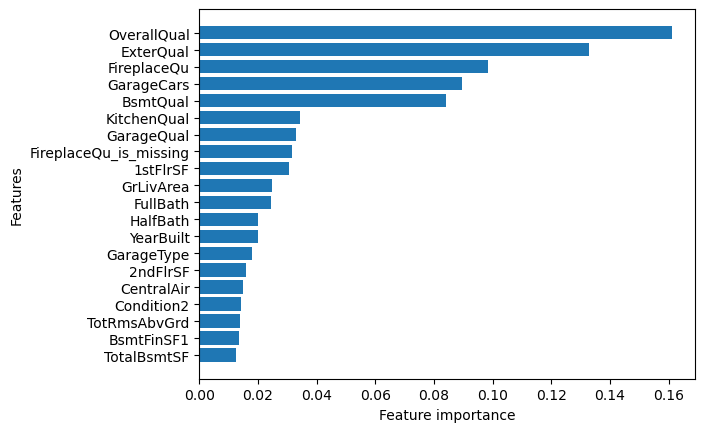

In [91]:
plot_features(X_train.columns, best_model.feature_importances_)